# Brain hemorrage detection using CNN model (question 4)

### Loading the data and preprocessing

In [1]:
# Importing the neccessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import cv2
import os

In [2]:
# Download the zip file containing the dataset from GitHub (I have hosted the given dataset on a public repo)

!wget https://github.com/Saumya4321/DL261-class-Datasets/raw/refs/heads/main/Dataset1.zip

--2024-10-20 12:38:10--  https://github.com/Saumya4321/DL261-class-Datasets/raw/refs/heads/main/Dataset1.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saumya4321/DL261-class-Datasets/refs/heads/main/Dataset1.zip [following]
--2024-10-20 12:38:11--  https://raw.githubusercontent.com/Saumya4321/DL261-class-Datasets/refs/heads/main/Dataset1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10048362 (9.6M) [application/zip]
Saving to: ‘Dataset1.zip’

Dataset1.zip        100%[===================>]   9.58M  --.-KB/s    in 0.1s    

2024-10-20 12:38:11 (97.2 MB/s) - ‘Dataset1.zip’ saved [100483

In [3]:
# Unzip the file downloaded - this makes the whole Dataset folder available in Colab's present runtime

!unzip Dataset1.zip

Archive:  Dataset1.zip
   creating: Dataset1/
   creating: Dataset1/TestFiles/
  inflating: Dataset1/TestFiles/0.jpg  
  inflating: Dataset1/TestFiles/1.jpg  
  inflating: Dataset1/TestFiles/10.jpg  
  inflating: Dataset1/TestFiles/11.jpg  
  inflating: Dataset1/TestFiles/12.jpg  
  inflating: Dataset1/TestFiles/13.jpg  
  inflating: Dataset1/TestFiles/14.jpg  
  inflating: Dataset1/TestFiles/15.jpg  
  inflating: Dataset1/TestFiles/16.jpg  
  inflating: Dataset1/TestFiles/17.jpg  
  inflating: Dataset1/TestFiles/18.jpg  
  inflating: Dataset1/TestFiles/19.jpg  
  inflating: Dataset1/TestFiles/2.jpg  
  inflating: Dataset1/TestFiles/20.jpg  
  inflating: Dataset1/TestFiles/21.jpg  
  inflating: Dataset1/TestFiles/22.jpg  
  inflating: Dataset1/TestFiles/23.jpg  
  inflating: Dataset1/TestFiles/24.jpg  
  inflating: Dataset1/TestFiles/25.jpg  
  inflating: Dataset1/TestFiles/26.jpg  
  inflating: Dataset1/TestFiles/27.jpg  
  inflating: Dataset1/TestFiles/28.jpg  
  inflating: Dataset1/

In [4]:
# specify the folder where the images are stored
image_folder = '/content/Dataset1/TrainFiles/'

# Specify the folder where the masks are stored
mask_folder = '/content/Dataset1/TrainMask/'


In the below code cell, the data is being loaded into a dictionary along with its label. The label is dynamically created according to whether the mask is all black for has atleast one bright pixel.

The preprocessing tasks done on the images are -


1.   Normalizing the scan image
2.   Reading the images as grayscale



In [5]:
# Load all the training images and masks into one dictionary

train_data = {}

for filename in os.listdir(image_folder):
  img_path = os.path.join(image_folder+filename)
  mask_path = os.path.join(mask_folder, filename[:-3]+"png") # as the masks are saved in same name as its corresponding scan

  # Reading the images using OpenCV library
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # reading them as grayscale images
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

 # Normalizing both the images and masks such that they now lie in a range from 0 to 1
  img=img/255
  mask=mask/255

 # Creating labels for the data based on whether the mask image is all black or it has some meaningful mask
  if len(mask[mask>0]):
    label = [1,0]
  else:
    label = [0,1]

  # finally saving our data as a tuple
  train_data[filename] = (img, label)

In [6]:
# Separating the images and their labels
train_images = [train_data[key][0] for key in train_data.keys()]
train_labels = [train_data[key][1] for key in train_data.keys()]

# Converting them into numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In the below code cell, augmentation of the available data is done. This is because the given dataset has very less images to efficiently train a Deep learning model. Hence, data augmentation is applied to help the model learn the classes better.

The data augmentation transformations applied are -


1.   Rotation
2.   Zooming in and out
3.  Horizontal flip



In [7]:

# Resizing the data so that channel information is also captured
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)

# ImageDataGenerator instance is created for desired data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented batches
batch_size = 32
generator = datagen.flow(
    train_images,
    train_labels,
    batch_size=batch_size
)

# Fetch a batch of augmented images and labels
augmented_images, augmented_labels = next(generator)

# Create a TensorFlow dataset
train_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Apply batching, shuffling, and prefetching
train_data = train_data.batch(batch_size).cache().shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

Now we load the validation dataset too.

In [8]:
# Load all the validation images and masks into one dictionary

image_folder = '/content/Dataset1/ValFiles/'

# Specify the folder where the masks are stored
mask_folder = '/content/Dataset1/ValMask/'

val_data = {}

# reading the validation data from its directory
for filename in os.listdir(image_folder):
  img_path = os.path.join(image_folder+filename)
  mask_path = os.path.join(mask_folder, filename[:-3]+"png") # as the masks are saved in same name as its corresponding scan

 # both the scan and the masks are read as grayscale images
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Normalizing the images
  img=img/255
  mask=mask/255

# Generating the labels for the scans
  if len(mask[mask>0]):
    label = [1,0]
  else:
    label = [0,1]
  val_data[filename] = (img, label)

In [9]:
# Getting the validation data into a suitable format

# Separating the images and labels
val_images = [val_data[key][0] for key in val_data.keys()]
val_labels = [val_data[key][1] for key in val_data.keys()]

# Converting them into numpy arrays
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Creating a custom Tensorflow dataset
val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_data = val_data.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building and Training the model

A Deep CNN network is chosen as the model in this case. We are having 5 layers of CNN, maxpooling and dropout. After these 5 repetitions, a flattening layer is applied to bring the output to single dimension.

 After that, two fully connected dense layers are added to the model for the class prediction. The final layer which gives the prediction is a dense layer with activation function of softmax, and gives 2 outputs, pertaining to the two classes - has hemorrage and no hemorrage.

In [10]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import layers, regularizers

# Define the L2 regularization factor
l2_factor = 0.0001

In [11]:
# Initialising the CNN
model = Sequential()

# first add a separate input layer
model.add(keras.layers.Input(shape=(256, 256, 1)))

# Adding first convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a second convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a third convolutional layer
model.add(layers.Conv2D(256, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a fourth convolutional layer
model.add(layers.Conv2D(512, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a fifth convolutional layer
model.add(layers.Conv2D(1024, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Flattening
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))

# Full connection
model.add(layers.Dense(units = 512, activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(2, activation='softmax'))



In [12]:
# Generating a summary of the constructed model

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 6, 6, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,145,346 (95.92 MB)

 Trainable params: 25,145,346 (95.92 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compiling the model
model.compile(loss = 'binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics = ['acc'])

In [14]:
# Defining a callback function for custom learning rate scheduler -> it automatically reduces the learning rate if validation loss hits a plateau

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [15]:
# Defining a custom learning rate scheduler, to vary the learning rate after a warmup of 7 epochs
# A Cosine annealing learning rate scheduler is defined

EPOCHS_PER_CYCLE = 10
MAX_LR = 1e-3
MIN_LR = 1e-4
N_WARMUP_EPOCHS = 7
RATE = (MAX_LR - MIN_LR) / N_WARMUP_EPOCHS

from math import pi, cos, floor

def scheduler(epoch, lr):
    if epoch <= N_WARMUP_EPOCHS:
        return epoch * RATE + MIN_LR
    cos_inner = (pi * ((epoch-N_WARMUP_EPOCHS) % EPOCHS_PER_CYCLE)) / (EPOCHS_PER_CYCLE)
    return MAX_LR/2 * (cos(cos_inner) + 1)



In [16]:
# implementing early stopping to reduce overfitting

Early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

callbacks = [keras.callbacks.LearningRateScheduler(scheduler), lr_callback, Early_stopping]

In [17]:
# Fitting the model on our training data

history = model.fit(train_data, epochs=40, validation_data=val_data, callbacks = callbacks)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 66s 66s/step - acc: 0.5625 - loss: 0.9224 - val_acc: 0.5000 - val_loss: 0.9180 - learning_rate: 1.0000e-04
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - acc: 0.5625 - loss: 0.9020 - val_acc: 0.5700 - val_loss: 0.9117 - learning_rate: 2.2857e-04
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - acc: 0.6875 - loss: 0.8597 - val_acc: 0.5600 - val_loss: 0.9421 - learning_rate: 3.5714e-04
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 114s 114s/step - acc: 0.7188 - loss: 0.8245 - val_acc: 0.5200 - val_loss: 1.0449 - learning_rate: 4.8571e-04
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - acc: 0.6562 - loss: 1.0824 - val_acc: 0.5000 - val_loss: 1.1082 - learning_rate: 6.1429e-04
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 62s 62s/step - acc: 0.5938 - loss: 1.0844 - val_acc: 0.5000 - val_loss: 0.9124 - learning_rate: 7.4286e-04
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 66s 66s/step - acc: 0.7500 - loss: 0.8476 - val_acc: 0.5200 - val_loss: 0.9053 - learning_rate: 8.7143e-

In [18]:
# Defining a function to extract history from the model and plot the metrics as graphs

def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

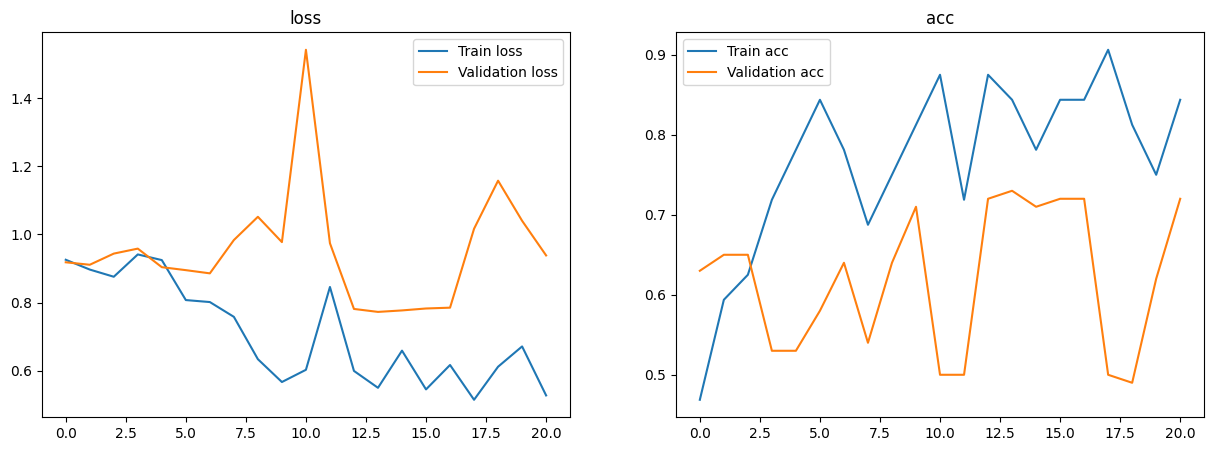

In [ ]:
# Plotting the graphs of variation of training metrics over epochs

show_history(history)

### Testing the model on Dataset1 test images

In [19]:
# Load all the test images and masks into one dictionary

image_folder = '/content/Dataset1/TestFiles/'

# Specify the folder where the masks are stored
mask_folder = '/content/Dataset1/TestMask/'

test_data = {}

for filename in os.listdir(image_folder):
  img_path = os.path.join(image_folder+filename)
  mask_path = os.path.join(mask_folder, filename[:-3]+"png") # as the masks are saved in same name as its corresponding scan

  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

  img=img/255
  mask=mask/255

  if len(mask[mask>0]):
    label = [1,0]
  else:
    label = [0,1]
  test_data[filename] = (img, label)

In [20]:
# bring the test images into a  suitable data structure

test_images = [test_data[key][0] for key in test_data.keys()]
test_labels = [test_data[key][1] for key in test_data.keys()]

test_images = np.array(test_images)
test_labels = np.array(test_labels)


test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_data = test_data.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.7661 - loss: 0.8100
Test Loss: 0.8120
Test Accuracy: 0.7800


In [22]:
pred_probs = model.predict(test_data)

# Convert probabilities to binary predictions using a threshold of 0.5
predicted_labels = (pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

true_labels = test_labels

# Get classification reports
report1 = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"])


print("Classification Report for Dataset1:\n", report1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
Classification Report for Dataset1:
               precision    recall  f1-score   support

     Class 0       0.85      0.68      0.76        50
     Class 1       0.73      0.88      0.80        50

   micro avg       0.78      0.78      0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100
 samples avg       0.78      0.78      0.78       100



### Testing the model on Dataset2 test data

In [23]:
# Download the zip file containing the dataset from GitHub (I have hosted the given dataset on a public repo)

!wget https://github.com/Saumya4321/DL261-class-Datasets/raw/refs/heads/main/Dataset2.zip

# Unzip the file downloaded - this makes the whole Dataset folder available in Colab's present runtime

!unzip Dataset2.zip

--2024-10-20 12:56:42--  https://github.com/Saumya4321/DL261-class-Datasets/raw/refs/heads/main/Dataset2.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Saumya4321/DL261-class-Datasets/refs/heads/main/Dataset2.zip [following]
--2024-10-20 12:56:42--  https://raw.githubusercontent.com/Saumya4321/DL261-class-Datasets/refs/heads/main/Dataset2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2267746 (2.2M) [application/zip]
Saving to: ‘Dataset2.zip’

Dataset2.zip        100%[===================>]   2.16M  --.-KB/s    in 0.07s   

2024-10-20 12:56:43 (32.3 MB/s) - ‘Dataset2.zip’ saved [2267746

In [24]:
# specify the folder where the images are stored
image_folder = '/content/Dataset2/Test/'

# Specify the folder where the masks are stored
labels_file = '/content/Dataset2/Test.csv'

In [25]:
# Load all the test images and labels into one dictionary

test_data_2 = {}

test_csv = pd.read_csv(labels_file)

for filename in os.listdir(image_folder):
  img_path = os.path.join(image_folder+filename)
  item_num_in_csv = int(filename[:-4])
  class_num = test_csv['label'][item_num_in_csv]

  # Reading the image using OpenCV library
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # reading them as grayscale images

 # Normalizing the image such that it now lies in a range from 0 to 1
  img=img/255

 # One-hot encoding of the labels
  if class_num:
    label = [1,0]
  else:
    label = [0,1]

  # finally saving our data as a tuple
  test_data_2[filename] = (img, label)

In [26]:
# bring the test images into a  suitable data structure

test_images_2 = [test_data_2[key][0] for key in test_data_2.keys()]
test_labels_2 = [test_data_2[key][1] for key in test_data_2.keys()]

test_images_2 = np.array(test_images_2)
test_labels_2 = np.array(test_labels_2)


test_data_2 = tf.data.Dataset.from_tensor_slices((test_images_2, test_labels_2))
test_data_2 = test_data_2.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy = model.evaluate(test_data_2)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.6161 - loss: 0.8815
Test Loss: 0.8981
Test Accuracy: 0.6167


In [28]:
pred_probs_2 = model.predict(test_data_2)

# Convert probabilities to binary predictions using a threshold of 0.5
predicted_labels_2 = (pred_probs_2 > 0.5).astype(int)

from sklearn.metrics import classification_report

true_labels_2 = test_labels_2

# Get classification reports
report2 = classification_report(true_labels_2, predicted_labels_2, target_names=["Class 0", "Class 1"])


print("Classification Report for Dataset2:\n", report1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report for Dataset2:
               precision    recall  f1-score   support

     Class 0       0.85      0.68      0.76        50
     Class 1       0.73      0.88      0.80        50

   micro avg       0.78      0.78      0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100
 samples avg       0.78      0.78      0.78       100



### (a) Finetuning the model over dataset 2 and reporting the metrics over test data of both datasets again

In [29]:
# Load the train data of dataset 2

# specify the folder where the images are stored
image_folder = '/content/Dataset2/Train/'

# Specify the folder where the masks are stored
labels_file = '/content/Dataset2/Train.csv'


# Load all the training images and masks into one dictionary

train_data_2 = {}

train_csv = pd.read_csv(labels_file)

for filename in os.listdir(image_folder):
  img_path = os.path.join(image_folder+filename)
  item_num_in_csv = int(filename[:-4])
  class_num = train_csv['label'][item_num_in_csv]

  # Reading the image using OpenCV library
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # reading them as grayscale images

 # Normalizing the image such that it now lies in a range from 0 to 1
  img=img/255

 # One hot encoding the labels
  if class_num:
    label = [1,0]
  else:
    label = [0,1]

  # finally saving our data as a tuple
  train_data_2[filename] = (img, label)


# bring the training images into a  suitable data structure

train_images_2 = [train_data_2[key][0] for key in train_data_2.keys()]
train_labels_2 = [train_data_2[key][1] for key in train_data_2.keys()]



train_images_2 = np.array(train_images_2)
train_labels_2 = np.array(train_labels_2)

# Resizing the data so that channel information is also captured
train_images_2 = train_images_2.reshape(train_images_2.shape[0], train_images_2.shape[1], train_images_2.shape[2], 1)

from sklearn.model_selection import train_test_split
train_images_2, val_images_2, train_labels_2, val_labels_2 = train_test_split(
    train_images_2, train_labels_2, test_size=0.3, random_state=42
)

# Creating a custom Tensorflow dataset

train_data_2 = tf.data.Dataset.from_tensor_slices((train_images_2, train_labels_2))
train_data_2 = train_data_2.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

val_data_2 = tf.data.Dataset.from_tensor_slices((val_images_2, val_labels_2))
val_data_2 = val_data_2.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

In [30]:
# ReCompiling the model with a smaller learning rate
model.compile(loss = 'binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-4),
              metrics = ['acc'])

In [31]:
# Fitting the model on our training data

new_history = model.fit(train_data_2, epochs=20,validation_data=val_data_2, callbacks = callbacks)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - acc: 0.5506 - loss: 0.8858 - val_acc: 0.4444 - val_loss: 0.8954 - learning_rate: 1.0000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - acc: 0.5640 - loss: 0.8672 - val_acc: 0.5926 - val_loss: 0.8518 - learning_rate: 2.2857e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - acc: 0.5593 - loss: 0.8334 - val_acc: 0.4815 - val_loss: 0.8117 - learning_rate: 3.5714e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - acc: 0.5395 - loss: 0.7837 - val_acc: 0.7778 - val_loss: 0.7164 - learning_rate: 4.8571e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - acc: 0.5186 - loss: 0.7469 - val_acc: 0.8519 - val_loss: 0.6800 - learning_rate: 6.1429e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 7s/step - acc: 0.6685 - loss: 0.6672 - val_acc: 0.7778 - val_loss: 0.6021 - learning_rate: 7.4286e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - acc: 0.6891 - loss: 0.8615 - val_acc: 0.7037 - val_loss: 0.8219 - learning_rate: 8.7143e-04
Epoch 

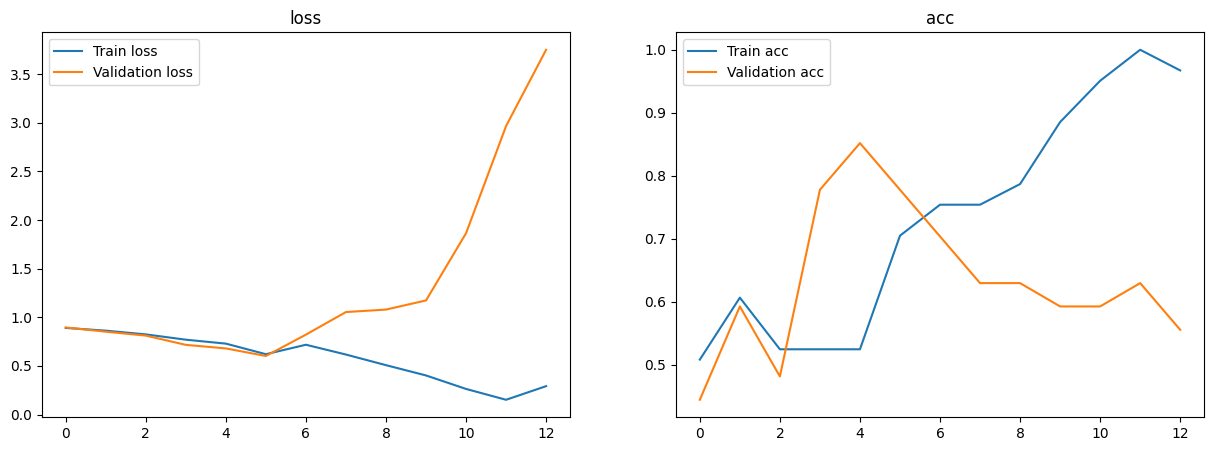

In [32]:
show_history(new_history)

In [33]:
# reporting test metric scores over test data from dataset2
# Reshape the test images to include the channel dimension
test_images_2 = test_images_2.reshape(test_images_2.shape[0], test_images_2.shape[1], test_images_2.shape[2], 1)

# Create the test dataset with the same structure as the training and validation datasets
test_data_2 = tf.data.Dataset.from_tensor_slices((test_images_2, test_labels_2))
test_data_2 = test_data_2.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)
# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy = model.evaluate(test_data_2)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.7128 - loss: 0.6891
Test Loss: 0.7421
Test Accuracy: 0.7167


In [34]:
pred_probs_3 = model.predict(test_data_2)

# Convert probabilities to binary predictions using a threshold of 0.5
predicted_labels_3 = (pred_probs_3 > 0.5).astype(int)

from sklearn.metrics import classification_report

true_labels_2 = test_labels_2

# Get classification reports
report2 = classification_report(true_labels_2, predicted_labels_3, target_names=["Class 0", "Class 1"])


print("Classification Report for fine tuned model on Dataset 2:\n", report1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report for fine tuned model on Dataset 2:
               precision    recall  f1-score   support

     Class 0       0.85      0.68      0.76        50
     Class 1       0.73      0.88      0.80        50

   micro avg       0.78      0.78      0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100
 samples avg       0.78      0.78      0.78       100



In [35]:
# Load all the test images and masks into one dictionary

image_folder = '/content/Dataset1/TestFiles/'

# Specify the folder where the masks are stored
mask_folder = '/content/Dataset1/TestMask/'

test_data_4 = {}

for filename in os.listdir(image_folder):
  img_path = os.path.join(image_folder+filename)
  mask_path = os.path.join(mask_folder, filename[:-3]+"png") # as the masks are saved in same name as its corresponding scan

  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

  img=img/255
  mask=mask/255

  if len(mask[mask>0]):
    label = [1,0]
  else:
    label = [0,1]
  test_data_4[filename] = (img, label)

In [36]:
# bring the test images into a  suitable data structure

test_images_4 = [test_data_4[key][0] for key in test_data_4.keys()]
test_labels_4 = [test_data_4[key][1] for key in test_data_4.keys()]

test_images_4 = np.array(test_images_4)
test_labels_4 = np.array(test_labels_4)

# Resizing the data so that channel information is also captured
test_images_4 = test_images_4.reshape(test_images_4.shape[0], test_images_4.shape[1], test_images_4.shape[2], 1)



test_data_4 = tf.data.Dataset.from_tensor_slices((test_images_4, test_labels_4))
test_data_4 = test_data_4.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

In [37]:
# Testing it on test data of dataset 1

# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy = model.evaluate(test_data_4)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

pred_probs_4 = model.predict(test_data_4)

# Convert probabilities to binary predictions using a threshold of 0.5
predicted_labels_4 = (pred_probs_4 > 0.5).astype(int)

from sklearn.metrics import classification_report

true_labels = test_labels

# Get classification reports
report1 = classification_report(true_labels, predicted_labels_4, target_names=["Class 0", "Class 1"])


print("Classification Report for fine tuned model on Dataset1:\n", report1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - acc: 0.6060 - loss: 0.8528
Test Loss: 0.8861
Test Accuracy: 0.6000
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
Classification Report for fine tuned model on Dataset1:
               precision    recall  f1-score   support

     Class 0       0.56      0.98      0.71        50
     Class 1       0.92      0.22      0.35        50

   micro avg       0.60      0.60      0.60       100
   macro avg       0.74      0.60      0.53       100
weighted avg       0.74      0.60      0.53       100
 samples avg       0.60      0.60      0.60       100

